## Section 1. Load the database 🚗

In [ ]:
import sqlite3
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
####################################
##### CONNECT TO THE DATABASE ######
####################################
%load_ext sql
%sql sqlite:///drive/MyDrive/ml20.sqlite

'Connected: @drive/MyDrive/ml20.sqlite'

In [ ]:
%%sql
-- show all tables
SELECT tbl_name FROM sqlite_master

 * sqlite:///drive/MyDrive/ml20.sqlite
Done.


tbl_name
customers
products
receipt_lines
receipts
stores
receipts
receipts
receipts
receipt_lines
receipt_lines


In [ ]:
sql = '''
SELECT *
FROM customers
'''

receipt_lines = %sql {sql}
receipt_lines.DataFrame()

 * sqlite:///drive/MyDrive/ml20.sqlite
Done.


,customer_id,first,last,dob
0,6,None,Bryant,None
1,8,None,Beabout,None
2,11,None,Schmidt,None
3,12,None,Meek,None
4,14,Carolyn,Daugherty,1989-10-31
...,...,...,...,...
5418,16319,None,Galloway,None
5419,16321,Genny,Jeanette,1981-03-27
5420,16322,None,Gillespie,None
5421,16326,None,Foxman,None


# Section 2. Feature Engineering 👩🏻‍🔬

**Task1: Creating New Tables**

In [ ]:
# -- Create new table "receipt summary" which will give summary amount and quantity of each receipt_id
%%sql
CREATE TABLE 'receipt_summary' ('receipt_id' int, 'total_qty' int,  'total_value' int )

In [ ]:
# -- Insert data into the table
%%sql
INSERT INTO 'receipt_summary'        
SELECT receipt_id, sum(qty),sum(value)
FROM  receipt_lines
GROUP BY receipt_id

In [ ]:
# -- Check the new table
sql = '''
SELECT *
FROM receipt_summary
'''

receipt_summary = %sql {sql}
receipt_summary.DataFrame()

 * sqlite:///drive/MyDrive/ml20.sqlite
Done.


,receipt_id,total_qty,total_value
0,1,12,11.21
1,2,3,14.85
2,3,24,41.69
3,4,8,19.97
4,5,1,8.51
...,...,...,...
64223,68855,1,20.34
64224,68856,11,12.95
64225,68857,17,34.65
64226,68858,2,0.96


In [ ]:
# -- Create a new table "purchase_data4" 
# -- The table combines "receipt summary", purchases timestamp and customer_id based on receipt_id
# -- Each date in the dataset is lablelled with a numnber representing the order of the date

%%sql
CREATE TABLE 'purchase_data4' ('receipt_id' int, 'purchased_at' date, 'customer_id' int, 'total_qty' int,  'total_value' int,'store_code' int,  'day' int )

In [ ]:
# -- Insert data into the table
%%sql
INSERT INTO 'purchase_data4'        
SELECT receipts.receipt_id,purchased_at,customer_id,total_qty,total_value, store_code, julianday(purchased_at) - julianday('2020-07-22') AS day
FROM receipts
INNER JOIN receipt_summary ON receipts.receipt_id = receipt_summary.receipt_id
ORDER BY purchased_at

In [ ]:
# -- Check the new table

sql = '''
SELECT *
FROM purchase_data4
'''

purchase_data = %sql {sql}
purchase_data.DataFrame()

In [ ]:
# -- Create a new table "location_counts"
# -- It lists the count of visit to each city of each customer in the past 5 months
%%sql
CREATE TABLE 'location_counts' ('customer_id' int,  'Nottingham' int, 'Birmingham' int, 'London' int )

In [ ]:
# -- Insert data into the table
%%sql
INSERT INTO 'location_counts'        
SELECT customer_id,
        
        SUM (CASE WHEN day > (608-31)-(31*4) AND store_code == 0 THEN 1 ELSE 0 END) as Nottingham,
        SUM (CASE WHEN day > (608-31)-(31*4) AND store_code == 1 THEN 1 ELSE 0 END) as Birmingham,
        SUM (CASE WHEN day > (608-31)-(31*4) AND store_code == 3 OR 4 THEN 1 ELSE 0 END) as London
      

FROM purchase_data4
GROUP BY customer_id  

In [ ]:
sql = '''
SELECT *
FROM location_counts
'''
location_counts = %sql {sql}
location_counts.DataFrame()

 * sqlite:///drive/MyDrive/ml20.sqlite
Done.


,customer_id,Nottingham,Birmingham,London
0,6,0,0,1
1,8,0,0,2
2,11,0,0,1
3,12,0,6,15
4,14,0,0,56
...,...,...,...,...
5354,16319,0,0,3
5355,16321,0,0,9
5356,16322,0,0,14
5357,16326,0,0,1


In [ ]:
# -- Create a new table "customer_location"
# -- Customers location is decided based on the most visited shops in the past 5 months
%%sql
CREATE TABLE 'customer_location' ('city' varchar, 'customer_id' int)

 * sqlite:///drive/MyDrive/ml20.sqlite
Done.


[]

In [ ]:
# -- Insert data into the table
%%sql
INSERT INTO 'customer_location'    
SELECT CASE MAX(Nottingham,Birmingham, London)
          WHEN  Nottingham   THEN 'Nottingham'
          WHEN Birmingham     THEN 'Birmingham'
          WHEN London    THEN 'London'
       END AS city, customer_id
FROM   location_counts
GROUP BY customer_id


 * sqlite:///drive/MyDrive/ml20.sqlite
5359 rows affected.


[]

In [ ]:
# -- Take a look at the table
sql = '''
SELECT *
FROM customer_location
'''
df = %sql {sql}
df.DataFrame()


 * sqlite:///drive/MyDrive/ml20.sqlite
Done.


,city,customer_id
0,London,6
1,London,8
2,London,11
3,London,12
4,London,14
...,...,...
5354,London,16319
5355,London,16321
5356,London,16322
5357,London,16326


In [ ]:
# -- Create a new table summarizing purchase datails including purchase date, amount, qty, recepit_id, customer_id, store_code, and customer location
%%sql
CREATE TABLE 'purchase_details' ('receipt_id' int, 'purchased_at' date, 'customer_id' int, 'total_qty' int,  'total_value' int,'store_code' int,  'day' int , 'city' varchar )

 * sqlite:///drive/MyDrive/ml20.sqlite
Done.


[]

In [ ]:
# -- Combine purchase record and customer location data
# -- Insert data into the table
%%sql
INSERT INTO 'purchase_details'    
SELECT receipt_id, purchased_at, purchase_data4.customer_id , total_qty, total_value, store_code, day, city
FROM purchase_data4
INNER JOIN customer_location ON customer_location.customer_id = purchase_data4.customer_id
ORDER BY purchased_at


 * sqlite:///drive/MyDrive/ml20.sqlite
64228 rows affected.


[]

In [ ]:
sql = '''
SELECT *
FROM purchase_details
'''

purchase_details = %sql {sql}
purchase_details= purchase_details.DataFrame()

 * sqlite:///drive/MyDrive/ml20.sqlite
Done.


In [ ]:
# -- Get the day lable of current date
Current_day = max(purchase_details.day)
print(Current_day)

608


**Task2. Generating Time Series Dataframe with SQLite 🕰**

In [ ]:
# -- Input the reference day, output_window_size,tumbling_window_size information
output_window_size = 31
tumbling_window_size = 31
now = 608
reference_day = now - output_window_size 

In [ ]:
# -- Select the data from SQL table according to the conditions given above
sql = """
    SELECT customer_id,
        {ref_date} AS ref_day,
        COUNT(DISTINCT store_code ) as total_stores_count,
        city,
        SUM(CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN total_value ELSE 0 END) as output_spending,
        SUM(CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN total_value ELSE 0 END) as f1_spending,
        SUM(CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{ows} THEN total_value ELSE 0 END) as f2_spending,
        SUM(CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{ows}*2 THEN total_value ELSE 0 END) as f3_spending,
        SUM(CASE WHEN day > {ref_date}-{tws}*4 AND day <= {ref_date}-{ows}*3 THEN total_value ELSE 0 END) as f4_spending,

        SUM(CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN total_qty ELSE 0 END) as output_qty,
        SUM(CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN total_qty ELSE 0 END) as f1_qty,
        SUM(CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{ows} THEN total_qty ELSE 0 END) as f2_qty,
        SUM(CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{ows}*2 THEN total_qty ELSE 0 END) as f3_qty,
        SUM(CASE WHEN day > {ref_date}-{tws}*4 AND day <= {ref_date}-{ows}*3 THEN total_qty ELSE 0 END) as f4_qty,
      
        COUNT(DISTINCT CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN day END) as output_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN day END) as f1_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{tws} THEN day END) as f2_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{tws}*2 THEN day END) as f3_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*4 AND day <= {ref_date}-{tws}*3 THEN day END) as f4_frequency,

        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN day END) == 0 THEN 1 ELSE 0 END) as output_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN day END) == 0 THEN 1 ELSE 0 END) as f1_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{tws} THEN day END) == 0 THEN 1 ELSE 0 END) as f2_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{tws}*2 THEN day END) == 0 THEN 1 ELSE 0 END) as f3_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*4 AND day <= {ref_date}-{tws}*3 THEN day END) == 0 THEN 1 ELSE 0 END) as f4_churn  
     
    FROM purchase_details
    GROUP BY customer_id  
    """

In [ ]:
# -- Put the query result into a dataframe
df = %sql {sql.format(ref_date = reference_day, ows = output_window_size, tws = tumbling_window_size)}
df = df.DataFrame()
df = df.astype({"output_churn": bool, "f1_churn": bool, "f2_churn": bool, "f3_churn": bool, "f4_churn": bool})

 * sqlite:///drive/MyDrive/ml20.sqlite
Done.


In [ ]:
df

,customer_id,ref_day,total_stores_count,city,output_spending,f1_spending,f2_spending,f3_spending,f4_spending,output_qty,...,output_frequency,f1_frequency,f2_frequency,f3_frequency,f4_frequency,output_churn,f1_churn,f2_churn,f3_churn,f4_churn
0,6,577,1,London,0.00,0.00,0.00,0.00,0.00,0,...,0,0,0,0,0,True,True,True,True,True
1,8,577,2,London,0.00,0.00,0.00,0.00,0.00,0,...,0,0,0,0,0,True,True,True,True,True
2,11,577,1,London,0.00,0.00,0.00,0.00,0.00,0,...,0,0,0,0,0,True,True,True,True,True
3,12,577,1,London,4.67,0.00,3.13,1.19,11.87,7,...,1,0,1,1,3,False,True,False,False,False
4,14,577,1,London,10.54,13.76,0.00,11.12,0.00,3,...,1,3,0,2,0,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5354,16319,577,1,London,0.00,0.00,0.00,0.00,0.00,0,...,0,0,0,0,0,True,True,True,True,True
5355,16321,577,1,London,0.00,0.00,0.00,0.00,0.00,0,...,0,0,0,0,0,True,True,True,True,True
5356,16322,577,1,London,54.10,31.92,36.94,0.00,0.00,14,...,2,1,1,0,0,False,False,False,True,True
5357,16326,577,1,London,0.00,0.00,0.00,0.00,0.00,0,...,0,0,0,0,0,True,True,True,True,True


**Task4. Feature Correlation 🔎**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
# -- Define inputs and output feature
inputs = df.drop(['customer_id', 'ref_day', 'output_spending', 'output_qty', 'output_frequency','output_churn'], axis = 1)
outputs = df.output_churn

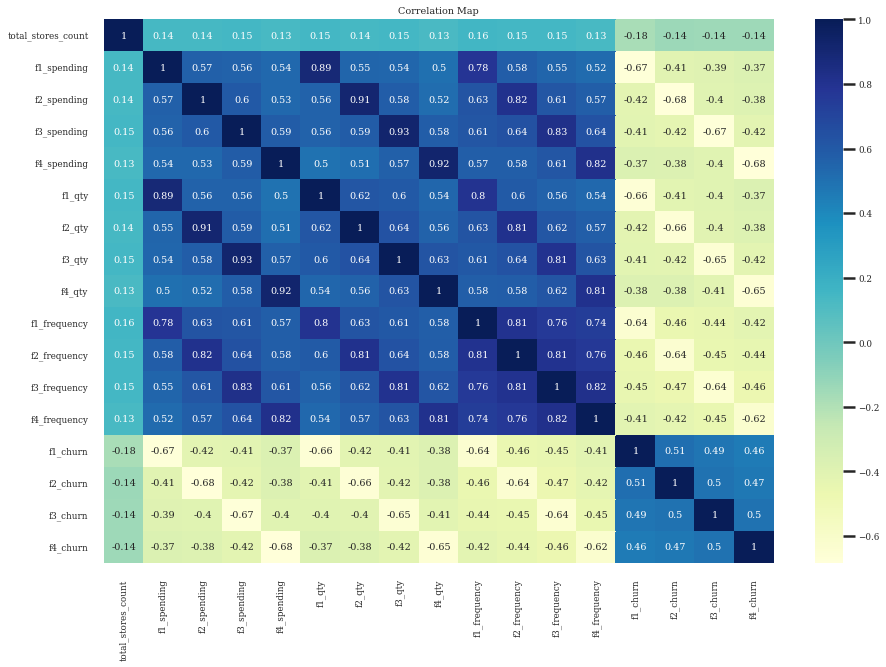

In [ ]:
# Visulize the data correlation with heatmap

sns.set_context("poster", font_scale = .4, rc={"grid.linewidth": 0.3})
plt.rcParams['font.family'] = "serif"
plt.figure(figsize=(15,10))
corr = inputs.corr()
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title('Correlation Map')
plt.show()

**Task 5. Finalize Input Features 📌**

In [ ]:
# -- Create a function to generate test/valid/traning dataset with reference day, tumbling window size and output window size

def get_dataset( reference_day , tumbling_window_size , output_window_size ):
    sql = """
    SELECT customer_id,
        {ref_date} AS ref_day,
        COUNT(DISTINCT store_code ) as total_stores_count,
        city,
        SUM(CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN total_value ELSE 0 END) as output_spending,
        SUM(CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN total_value ELSE 0 END) as f1_spending,
        SUM(CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{ows} THEN total_value ELSE 0 END) as f2_spending,
        SUM(CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{ows}*2 THEN total_value ELSE 0 END) as f3_spending,
        SUM(CASE WHEN day > {ref_date}-{tws}*4 AND day <= {ref_date}-{ows}*3 THEN total_value ELSE 0 END) as f4_spending,

      
        COUNT(DISTINCT CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN day END) as output_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN day END) as f1_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{tws} THEN day END) as f2_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{tws}*2 THEN day END) as f3_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*4 AND day <= {ref_date}-{tws}*3 THEN day END) as f4_frequency,

        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN day END) == 0 THEN 1 ELSE 0 END) as output_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN day END) == 0 THEN 1 ELSE 0 END) as f1_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{tws} THEN day END) == 0 THEN 1 ELSE 0 END) as f2_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{tws}*2 THEN day END) == 0 THEN 1 ELSE 0 END) as f3_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*4 AND day <= {ref_date}-{tws}*3 THEN day END) == 0 THEN 1 ELSE 0 END) as f4_churn  
     
    FROM purchase_details
    GROUP BY customer_id  
    """

    df = %sql {sql.format(ref_date = reference_day, tws = tumbling_window_size, ows = output_window_size)}
    df = df.DataFrame()
    df = df.astype({"output_churn": bool, "f1_churn": bool, "f2_churn": bool, "f3_churn": bool, "f4_churn": bool})

    return df.drop(columns = ['ref_day','output_spending', 'customer_id','output_frequency','output_churn'], inplace = False), df.output_churn

In [ ]:
# -- Split data into train,valid,test
output_window_size = 31
tumbling_window_size = 31
now =  608
reference_day = now - output_window_size 

X_test,y_test = get_dataset(reference_day,tumbling_window_size ,output_window_size)
X_valid,y_valid = get_dataset(now - 2*output_window_size,tumbling_window_size ,output_window_size)
X_train,y_train = get_dataset(now - 3*output_window_size,tumbling_window_size ,output_window_size)

 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
 * sqlite:///drive/MyDrive/ml20.sqlite
Done.


# Section3. Standardization ⛱


In [ ]:
# -- Calculate mean, standard deviation of training dataset in groups

# -- Spending
mean_spending = X_train.iloc[ : , 2:6].mean().mean()
std_spending = X_train.iloc[ : , 2:6].stack().std()

print('mean_spending:', mean_spending)
print('std_spending:',std_spending)

# -- Frequency
mean_frequency = X_train.iloc[ : , 6:10].mean().mean()
std_frequency = X_train.iloc[ : , 6:10].stack().std()

print('mean_frequency:', mean_frequency)
print('std_frequency:',std_frequency)




mean_spending: 8.523771225974997
std_spending: 21.655185464048245
mean_frequency: 0.5956801642097407
std_frequency: 1.5991711169863234


In [ ]:
# -- Create a function for standardization with the mean & std calculated above

def standardization( dataset ):
    dataset.iloc[ : , 2:6] = (dataset.iloc[ : , 2:6] - mean_spending)/std_spending
    dataset.iloc[ : , 6:10] = (dataset.iloc[ : , 6:10] - mean_frequency)/std_frequency

    return dataset
    


In [ ]:
X_train_scaled = standardization(X_train)
X_valid_scaled = standardization(X_valid)
X_test_scaled = standardization(X_test)

# Section 4. Machine Learning Models 🐍

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import  KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# -- Creat a list for models
list_of_models = []

# -- Set models with different parameters
svc1 = Pipeline( [
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse = False)), 
    ('model',LinearSVC(max_iter=30000, C = 0.001,class_weight="balanced") )
] )

svc2 = Pipeline( [
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse = False)), 
    ('model',LinearSVC(max_iter=30000, C = 0.001,class_weight={True:1,False:3}) )
] )

svc3 = Pipeline( [
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse = False)), 
    ('model',LinearSVC(max_iter=30000, C = 0.001,class_weight= {True:1, False:2} ) )
] )


svc4 = Pipeline( [
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse = False)), 
    ('model',LinearSVC(max_iter=30000, C = 0.01,class_weight="balanced") )
] )

svc5 = Pipeline( [
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse = False)), 
    ('model',LinearSVC(max_iter=30000, C = 0.01,class_weight={True:1,False:3}) )
] )

svc6 = Pipeline( [
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse = False)), 
    ('model',LinearSVC(max_iter=30000, C = 0.01,class_weight= {True:1, False:2} ) )
] )



rf1 = Pipeline( [
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse = False)), 
    ('model',RandomForestClassifier(n_estimators = 100, max_depth = 5 , min_samples_leaf= 2) )
] )

rf2 = Pipeline( [
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse = False)), 
    ('model',RandomForestClassifier(n_estimators = 100, max_depth = 10,min_samples_leaf= 2) )
] )

rf3 = Pipeline( [
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse = False)), 
    ('model',RandomForestClassifier(n_estimators = 100,max_depth = 15,min_samples_leaf= 2) )
] )

rf4 = Pipeline( [
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse = False)), 
    ('model',RandomForestClassifier(n_estimators = 100,max_depth = 5, min_samples_leaf= 5) )
] )

rf5 = Pipeline( [
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse = False)), 
    ('model',RandomForestClassifier( n_estimators = 100, max_depth = 10, min_samples_leaf= 5 ) )
] )

rf6 = Pipeline( [
    ('onehot',OneHotEncoder(handle_unknown='ignore',sparse = False)), 
    ('model',RandomForestClassifier(n_estimators = 100,max_depth = 15,min_samples_leaf= 5 ) )
] )




list_of_models += [svc1,svc2,svc3,svc4,svc5,svc6,rf1,rf2,rf3,rf4,rf5,rf6]

# Section 5. Parameter- Tuning & Model Evaluation 🧑🏻‍🔬

In [ ]:
# -- Model Evaluation via repeated temporal hold-out 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


# -- Baseline model
# -- Use the churn result in the latest period to predict
output_window_size = 31
tumbling_window_size = 31
total_holdout_sets = 3
now =  608
reference_day = now - tumbling_window_size
baseline_accuracy = []


# -- Evaluate the baseline model
for i in range (total_holdout_sets):
    X_valid,y_valid = get_dataset(now - 2*output_window_size,tumbling_window_size ,output_window_size)

    r = accuracy_score (y_valid, X_valid.f1_churn)
    baseline_accuracy.append(r)
    now = now - output_window_size

# -- Baseline model mean accuracy score
baseline_accuracy = np.mean(baseline_accuracy)


# -- Create lists to store model scores
accuracy = []
precision = []

# -- Loop through the model
for model in list_of_models:
    
    output_window_size = 31
    tumbling_window_size = 31
    now =  608 

    model_accuracy = []
    model_precision = []

    print('Computing model: {}'.format(model))
    run = 0
    for i in range(total_holdout_sets):
             # -- Generate training & validation datasets
             X_valid,y_valid = get_dataset(now - 2*output_window_size,tumbling_window_size ,output_window_size)
             X_train,y_train = get_dataset(now - 3*output_window_size,tumbling_window_size ,output_window_size)
             
             # -- Implement standardization 
             X_train_scaled = standardization(X_train)
             X_valid_scaled = standardization(X_valid)

             # -- Show the count of the loop
             run += 1
             print('{}/3'.format(run))
          
             # -- Fit the model with traning set
             model.fit(X_train_scaled, y_train)
             # -- Test the model with valid set
             preds = model.predict(X_valid_scaled)
             # -- Append model accuracy and precision score
             r = accuracy_score(y_valid, preds)
             model_accuracy.append(r)
             p = precision_score(y_valid, preds)
             model_precision.append(p)
                    
             now = now - output_window_size

    # Store the result
    accuracy.append(np.mean(model_accuracy))
    precision.append(np.mean(model_precision))


 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
Computing model: Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('model',
                 LinearSVC(C=0.001, class_weight='balanced', max_iter=30000))])
 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
1/3
 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
2/3
 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
3/3
Computing model: Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('model',
                 LinearSVC(C=0.001, class_weight={False: 3, True: 1},
                           max_iter=30000))])
 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
1/3
 * sqlite

In [ ]:
# -- Check the validatation results 
print('Model Accuracy:')
print(accuracy)
print('\n')
print('Model Precision:')
print(precision)

Model Accuracy:
[0.8272065683896249, 0.8250295453131803, 0.8423835292654102, 0.8250295453131803, 0.8235989301486596, 0.8395222989363686, 0.7851589226845804, 0.826522361137028, 0.8251539466318342, 0.7411830565403994, 0.7411830565403994, 0.7411830565403994]


Model Precision:
[0.8895431194993821, 0.8914098301875405, 0.8766107283345196, 0.8877392867368717, 0.8883730863096254, 0.8748825717198, 0.7791030336984105, 0.8186581916883594, 0.8170487449172367, 0.7411830565403994, 0.7411830565403994, 0.7411830565403994]


In [ ]:
# -- Check the baseline model performance
print('Baseline Predictor Accuracy:', baseline_accuracy)

Baseline Predictor Accuracy: 0.809292778503452


In [ ]:
# -- Get the best model
idx_of_best_model = precision.index(max(precision))
best_model = list_of_models[idx_of_best_model]

print('Model Accuracy:', accuracy[idx_of_best_model])
print('Model Precision:', max(precision))
print(best_model)


Model Accuracy: 0.8250295453131803
Model Precision: 0.8914098301875405
Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('model',
                 LinearSVC(C=0.001, class_weight={False: 3, True: 1},
                           max_iter=30000))])


# Section 6. Model Deployment 🏆

In [ ]:
X_test,y_test = get_dataset(now -output_window_size,tumbling_window_size ,output_window_size)
X_test_scaled = standardization(X_test)

# -- Test the best model with test dataset
preds = best_model.predict(X_test_scaled)
precision = precision_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)

# -- Model Performance
print('presicion:', precision)
print('accuracy:', accuracy)


 * sqlite:///drive/MyDrive/ml20.sqlite
Done.
presicion: 0.8866666666666667
accuracy: 0.8227281209180818


In [ ]:
# -- Train the best model with the entire dataset
# -- Get the dataset ready
X_train,y_train = get_dataset(now,tumbling_window_size ,output_window_size)

# -- Fit the model
best_model.fit(X_train,y_train)


 * sqlite:///drive/MyDrive/ml20.sqlite
Done.


Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False)),
                ('model',
                 LinearSVC(C=0.001, class_weight={False: 3, True: 1},
                           max_iter=30000))])

# Section 7. Prediction

In [ ]:
# -- Making prediction 
now = max(purchase_details.day)


sql = """
    SELECT customer_id,
        {ref_date} AS ref_day,
        COUNT(DISTINCT store_code ) as total_stores_count,
        city,
        SUM(CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN total_value ELSE 0 END) as f1_spending,
        SUM(CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN total_value ELSE 0 END) as f2_spending,
        SUM(CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{ows} THEN total_value ELSE 0 END) as f3_spending,
        SUM(CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{ows}*2 THEN total_value ELSE 0 END) as f4_spending,

      
        COUNT(DISTINCT CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN day END) as f1_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN day END) as f2_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{tws} THEN day END) as f3_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{tws}*2 THEN day END) as f4_frequency,

        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN day END) == 0 THEN 1 ELSE 0 END) as f1_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN day END) == 0 THEN 1 ELSE 0 END) as f2_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{tws} THEN day END) == 0 THEN 1 ELSE 0 END) as f3_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{tws}*2 THEN day END) == 0 THEN 1 ELSE 0 END) as f4_churn

  
    FROM purchase_details
    GROUP BY customer_id  
    """

df = %sql {sql.format(ref_date = reference_day, tws = tumbling_window_size, ows = output_window_size)}
df = df.DataFrame()
df = df.astype({ "f1_churn": bool, "f2_churn": bool, "f3_churn": bool, "f4_churn": bool})

inputs = df.drop(['customer_id', 'ref_day'], axis = 1)
inputs = standardization(inputs)


preds= best_model.predict(inputs)
preds = pd.DataFrame(preds,index= inputs.index, columns=['prediction'])

prediction = pd.concat([df.customer_id,inputs,preds], axis = 'columns')

prediction.head()

 * sqlite:///drive/MyDrive/ml20.sqlite
Done.


,customer_id,total_stores_count,city,f1_spending,f2_spending,f3_spending,f4_spending,f1_frequency,f2_frequency,f3_frequency,f4_frequency,f1_churn,f2_churn,f3_churn,f4_churn,prediction
0,6,1,London,-0.393613,-0.393613,-0.393613,-0.393613,-0.372493,-0.372493,-0.372493,-0.372493,True,True,True,True,True
1,8,2,London,-0.393613,-0.393613,-0.393613,-0.393613,-0.372493,-0.372493,-0.372493,-0.372493,True,True,True,True,True
2,11,1,London,-0.393613,-0.393613,-0.393613,-0.393613,-0.372493,-0.372493,-0.372493,-0.372493,True,True,True,True,True
3,12,1,London,-0.177961,-0.393613,-0.249075,-0.338661,0.252831,-0.372493,0.252831,0.252831,False,True,False,False,False
4,14,1,London,0.093106,0.241800,-0.393613,0.119889,0.252831,1.503479,-0.372493,0.878155,False,False,True,False,False


# Section 8. Pen Portraits👨🏽‍🎨*

In [ ]:
# -- Extracting the temporal data

output_window_size = 31
tumbling_window_size = 31
now =  608
reference_day = now - output_window_size 

sql = """
    SELECT customer_id,
        {ref_date} AS ref_day,
        COUNT(DISTINCT store_code ) as total_stores_count,
        city,
        SUM(CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN total_value ELSE 0 END) as output_spending,
        SUM(CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN total_value ELSE 0 END) as f1_spending,
        SUM(CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{ows} THEN total_value ELSE 0 END) as f2_spending,
        SUM(CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{ows}*2 THEN total_value ELSE 0 END) as f3_spending,
        SUM(CASE WHEN day > {ref_date}-{tws}*4 AND day <= {ref_date}-{ows}*3 THEN total_value ELSE 0 END) as f4_spending,

        SUM(CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN total_qty ELSE 0 END) as output_qty,
        SUM(CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN total_qty ELSE 0 END) as f1_qty,
        SUM(CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{ows} THEN total_qty ELSE 0 END) as f2_qty,
        SUM(CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{ows}*2 THEN total_qty ELSE 0 END) as f3_qty,
        SUM(CASE WHEN day > {ref_date}-{tws}*4 AND day <= {ref_date}-{ows}*3 THEN total_qty ELSE 0 END) as f4_qty,
      
        COUNT(DISTINCT CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN day END) as output_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN day END) as f1_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{tws} THEN day END) as f2_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{tws}*2 THEN day END) as f3_frequency,
        COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*4 AND day <= {ref_date}-{tws}*3 THEN day END) as f4_frequency,

        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date} AND day <= {ref_date}+{ows} THEN day END) == 0 THEN 1 ELSE 0 END) as output_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws} AND day <= {ref_date} THEN day END) == 0 THEN 1 ELSE 0 END) as f1_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*2 AND day <= {ref_date}-{tws} THEN day END) == 0 THEN 1 ELSE 0 END) as f2_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*3 AND day <= {ref_date}-{tws}*2 THEN day END) == 0 THEN 1 ELSE 0 END) as f3_churn,
        (CASE WHEN COUNT(DISTINCT CASE WHEN day > {ref_date}-{tws}*4 AND day <= {ref_date}-{tws}*3 THEN day END) == 0 THEN 1 ELSE 0 END) as f4_churn  
     
    FROM purchase_details
    GROUP BY customer_id  
    """

In [ ]:
df = %sql {sql.format(ref_date = reference_day, ows = output_window_size, tws = tumbling_window_size)}
df = df.DataFrame()
df = df.astype({"output_churn": bool, "f1_churn": bool, "f2_churn": bool, "f3_churn": bool, "f4_churn": bool})

 * sqlite:///drive/MyDrive/ml20.sqlite
Done.


In [ ]:
# -- Creat a subset of F1 active customers
active_f1 = df[df['f1_churn'] == False]
active_f1.head()

,customer_id,ref_day,total_stores_count,city,output_spending,f1_spending,f2_spending,f3_spending,f4_spending,output_qty,...,output_frequency,f1_frequency,f2_frequency,f3_frequency,f4_frequency,output_churn,f1_churn,f2_churn,f3_churn,f4_churn
4,14,577,1,London,10.54,13.76,0.00,11.12,0.00,3,...,1,3,0,2,0,False,False,True,False,True
7,28,577,1,London,33.11,7.27,12.91,14.39,81.90,35,...,2,1,2,1,4,False,False,False,False,False
8,32,577,1,Birmingham,0.00,43.96,0.00,0.00,0.00,0,...,0,1,0,0,0,True,False,True,True,True
10,38,577,2,London,23.06,63.30,61.10,44.87,29.69,29,...,2,4,6,4,3,False,False,False,False,False
13,47,577,1,London,6.57,14.79,0.00,0.00,0.00,9,...,1,1,0,0,0,False,False,True,True,True


In [ ]:
# -- Divide the active customers into two groups: Churn & non-churn
churn = active_f1 [active_f1['output_churn'] == True]
non_churn = active_f1 [active_f1['output_churn'] == False]

False    873
True     524
Name: output_churn, dtype: int64

The churn rate of active customer in f1 was 37.50894774516822% out of 1397 observations


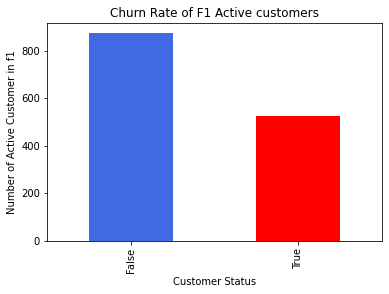

In [ ]:
# -- Visualize the percentage of churned/non-churned in the f1 active customers
summary = active_f1['output_churn'].value_counts()
print(summary)
print("\nThe churn rate of active customer in f1 was {}% out of {} observations".format(summary[1] / len(active_f1) * 100, len(active_f1)))

summary.plot(kind='bar',color = ['royalblue','red'])
plt.rcParams['font.family'] = "serif"
plt.title('Churn Rate of F1 Active customers')
plt.ylabel('Number of Active Customer in f1')
plt.xlabel('Customer Status');

<Figure size 1800x1152 with 0 Axes>

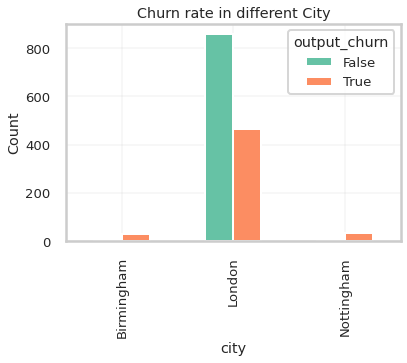

In [ ]:
# -- Visualize the percentage of churned/non-churned in the f1 active customers by different locations
plt.figure(figsize = (25,16))
sns.set_theme(style="whitegrid",palette="Set2")
sns.set_context("poster", font_scale = .6, rc={"grid.linewidth": 0.3})
pd.crosstab(active_f1.city,active_f1.output_churn).plot(kind = 'bar')
plt.title('Churn rate in different City')
plt.ylabel('Count');

In [ ]:
# -- Calculate the churn rate in each city

notts = active_f1[active_f1['city'] == "Nottingham"]
nott_rate = notts.output_churn.value_counts()
print('The churn ratio in Nottingham is', nott_rate[0]/len(notts)*100, '%')

bir = active_f1[active_f1['city'] == "Birmingham"]
bir_rate = bir.output_churn.value_counts()
print('The churn ratio in Birmingham is', bir_rate[0]/len(bir)*100, '%')

lon = active_f1[active_f1['city'] == "London"]
lon_rate = lon.output_churn.value_counts()
print('The churn ratio in London is', lon_rate[1]/len(lon)*100, '%')

The churn ratio in Nottingham is 20.0 %
The churn ratio in Birmingham is 20.0 %
The churn ratio in London is 35.09833585476551 %


In [ ]:
# -- Statistical Overview 
# -- Customer who churned
churn.describe() 

,customer_id,ref_day,total_stores_count,output_spending,f1_spending,f2_spending,f3_spending,f4_spending,output_qty,f1_qty,f2_qty,f3_qty,f4_qty,output_frequency,f1_frequency,f2_frequency,f3_frequency,f4_frequency
count,524.000000,524.0,524.000000,524.0,524.000000,524.000000,524.000000,524.000000,524.0,524.000000,524.000000,524.000000,524.000000,524.0,524.000000,524.000000,524.000000,524.000000
mean,7904.188931,577.0,1.154580,0.0,28.451069,9.067385,8.933130,8.807195,0.0,19.791985,6.772901,6.885496,6.704198,0.0,1.278626,0.582061,0.612595,0.570611
std,4844.305337,0.0,0.367095,0.0,26.717937,17.952341,17.633254,16.997352,0.0,18.422819,13.837211,13.982721,14.417110,0.0,0.582276,1.093586,1.258514,1.049800
min,32.000000,577.0,1.000000,0.0,0.990000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
25%,3608.500000,577.0,1.000000,0.0,10.252500,0.000000,0.000000,0.000000,0.0,7.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
50%,7753.000000,577.0,1.000000,0.0,21.270000,0.000000,0.000000,0.000000,0.0,14.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
75%,12389.000000,577.0,1.000000,0.0,38.545000,11.755000,12.780000,11.405000,0.0,28.000000,8.000000,8.000000,8.000000,0.0,1.000000,1.000000,1.000000,1.000000
max,16283.000000,577.0,3.000000,0.0,283.170000,145.610000,180.850000,102.220000,0.0,111.000000,88.000000,98.000000,91.000000,0.0,5.000000,12.000000,16.000000,8.000000


In [ ]:
# -- Statistical Overview 
# -- Customer who has not churned
non_churn.describe()

,customer_id,ref_day,total_stores_count,output_spending,f1_spending,f2_spending,f3_spending,f4_spending,output_qty,f1_qty,f2_qty,f3_qty,f4_qty,output_frequency,f1_frequency,f2_frequency,f3_frequency,f4_frequency
count,873.000000,873.0,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000
mean,8032.726231,577.0,1.215349,39.478534,38.823872,31.226850,29.876999,27.728110,28.589920,29.046964,23.776632,22.838488,21.043528,2.909507,2.931271,2.560137,2.516609,2.326460
std,4600.891603,0.0,0.433032,37.258283,35.909744,34.545973,34.431461,34.371121,27.473991,27.891769,27.830447,27.819294,26.790094,2.947525,2.842961,2.989103,2.972737,3.039488
min,14.000000,577.0,1.000000,0.990000,0.370000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,4073.000000,577.0,1.000000,14.780000,15.970000,6.950000,4.950000,1.060000,10.000000,11.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,7873.000000,577.0,1.000000,27.470000,28.640000,22.080000,20.780000,18.340000,20.000000,21.000000,16.000000,15.000000,13.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,11973.000000,577.0,1.000000,52.330000,50.270000,43.340000,40.850000,37.950000,38.000000,37.000000,32.000000,31.000000,29.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,16322.000000,577.0,3.000000,297.840000,364.740000,233.460000,275.490000,262.450000,206.000000,212.000000,196.000000,222.000000,167.000000,26.000000,28.000000,30.000000,28.000000,31.000000


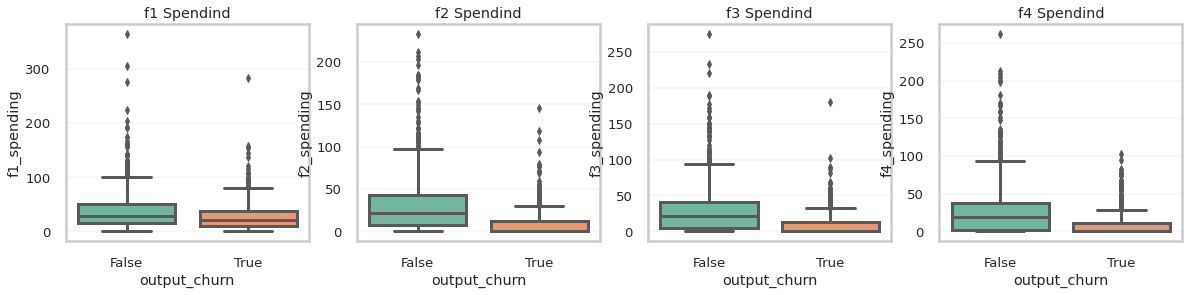

In [ ]:
# -- Statistical Overview 
# -- Visualize the spending over periods in the two groups
sns.set_theme(style="whitegrid",palette="Set2")
sns.set_context("poster", font_scale = .6, rc={"grid.linewidth": 0.3})

f, axes = plt.subplots(1, 4,figsize=(20,4))
sns.boxplot(y="f1_spending", x= "output_churn", data=active_f1,  orient='v' , ax=axes[0]).set_title('f1 Spendind')

sns.boxplot(y="f2_spending", x= "output_churn", data=active_f1,  orient='v' , ax=axes[1]).set_title('f2 Spendind')
sns.boxplot(y="f3_spending", x= "output_churn", data=active_f1,  orient='v' , ax=axes[2]).set_title('f3 Spendind')
sns.boxplot(y="f4_spending", x= "output_churn", data=active_f1,  orient='v' , ax=axes[3]).set_title('f4 Spendind');

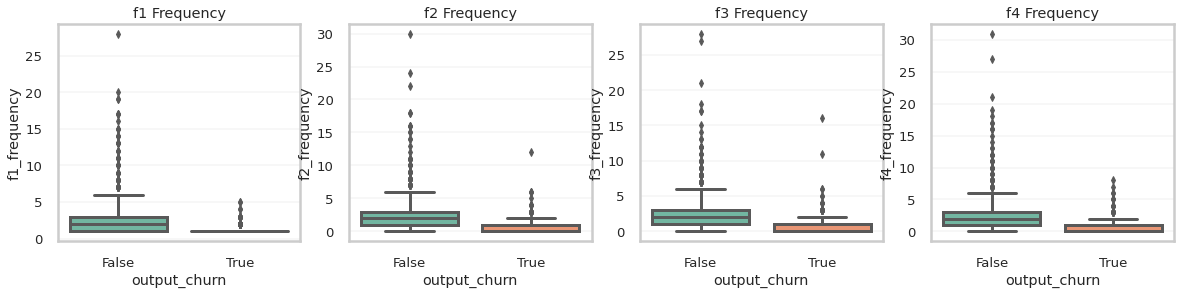

In [ ]:
# -- Statistical Overview 
# -- Visualize the visting frequency over periods in the two groups
sns.set_theme(style="whitegrid",palette="Set2")
sns.set_context("poster", font_scale = .6, rc={"grid.linewidth": 0.3})

f, axes = plt.subplots(1, 4,figsize=(20,4))
sns.boxplot(y="f1_frequency", x= "output_churn", data=active_f1,  orient='v' , ax=axes[0]).set_title('f1 Frequency')

sns.boxplot(y="f2_frequency", x= "output_churn", data=active_f1,  orient='v' , ax=axes[1]).set_title('f2 Frequency')
sns.boxplot(y="f3_frequency", x= "output_churn", data=active_f1,  orient='v' , ax=axes[2]).set_title('f3 Frequency')
sns.boxplot(y="f4_frequency", x= "output_churn", data=active_f1,  orient='v' , ax=axes[3]).set_title('f4 Frequency');